### This code is a demo of creating residual images from main images so our objective is to do it for all the official scan image and implement it on cnn.may be try checking out if we can add flatfield image for some accuracy in cnn(second objective)

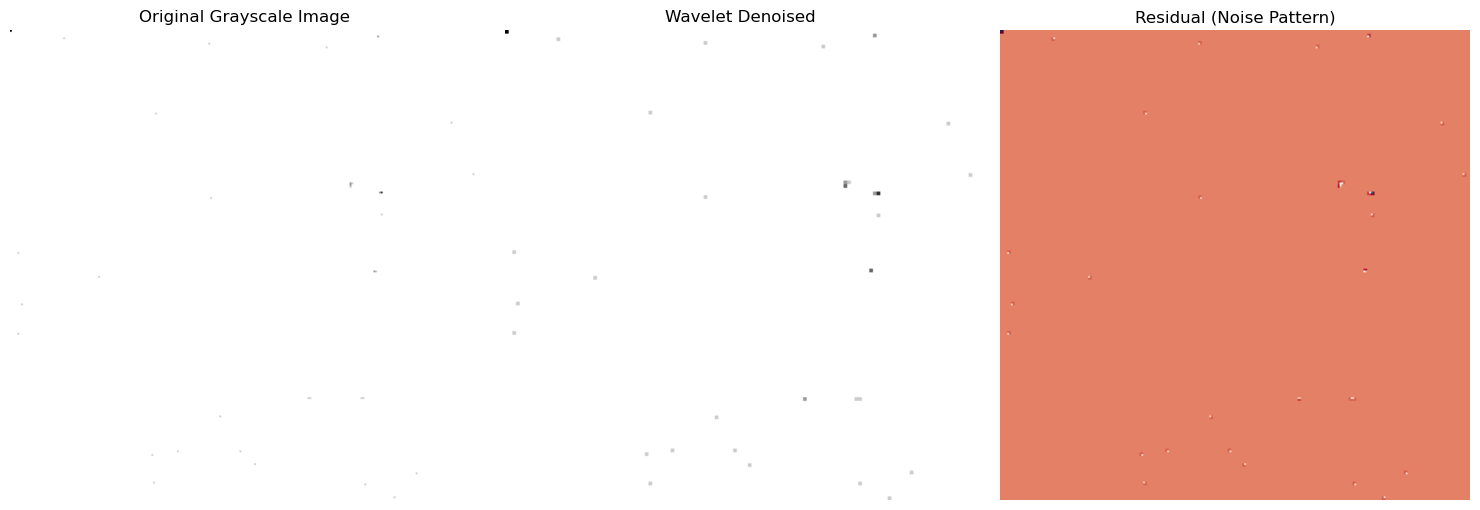

🧬 Extracted simple fingerprint feature (mean residual): 0.000000


In [ ]:
# ==============================
# Simple 1-Image Denoising + Residual Extraction Demo
# ==============================
import cv2
import numpy as np
import matplotlib.pyplot as plt
import pywt

# ---------------------------
# CONFIG
# ---------------------------
IMG_PATH = r"D:\Flatfield-20251014T111900Z-1-001\Flatfield\Canon120-1\300.tif"  # 👈 Change to your image path
IMG_SIZE = (512, 512)                    # Resize target

# ---------------------------
# Step 1: Load and preprocess
# ---------------------------
def preprocess_image(path):
    img = cv2.imread(path, cv2.IMREAD_COLOR)
    if img is None:
        raise FileNotFoundError(f"Image not found: {path}")
    gray = cv2.cvtColor(img, cv2.COLOR_BGR2GRAY)
    gray = cv2.resize(gray, IMG_SIZE, interpolation=cv2.INTER_AREA)
    gray = gray.astype(np.float32) / 255.0
    return gray

# ---------------------------
# Step 2: Wavelet denoising
# ---------------------------
def denoise_wavelet(img):
    coeffs = pywt.dwt2(img, 'haar')
    cA, (cH, cV, cD) = coeffs
    cH[:] = 0; cV[:] = 0; cD[:] = 0  # Zero out detail coeffs for denoising
    return pywt.idwt2((cA, (cH, cV, cD)), 'haar')

# ---------------------------
# Step 3: Residual computation (image - denoised)
# ---------------------------
def compute_residual(img):
    denoised = denoise_wavelet(img)
    residual = img - denoised
    return residual, denoised

# ---------------------------
# Step 4: Feature (Fingerprint) extraction — just visualize for one image
# ---------------------------
gray = preprocess_image(IMG_PATH)
residual, denoised = compute_residual(gray)

# ---------------------------
# Step 5: Visualization
# ---------------------------
plt.figure(figsize=(15,5))

plt.subplot(1,3,1)
plt.imshow(gray, cmap='gray')
plt.title("Original Grayscale Image")
plt.axis('off')

plt.subplot(1,3,2)
plt.imshow(denoised, cmap='gray')
plt.title("Wavelet Denoised")
plt.axis('off')

plt.subplot(1,3,3)
plt.imshow(residual, cmap='RdBu_r')
plt.title("Residual (Noise Pattern)")
plt.axis('off')

plt.tight_layout()
plt.show()

# Optional fingerprint feature (mean residual intensity)
fingerprint_value = np.mean(residual)
print(f"🧬 Extracted simple fingerprint feature (mean residual): {fingerprint_value:.6f}")


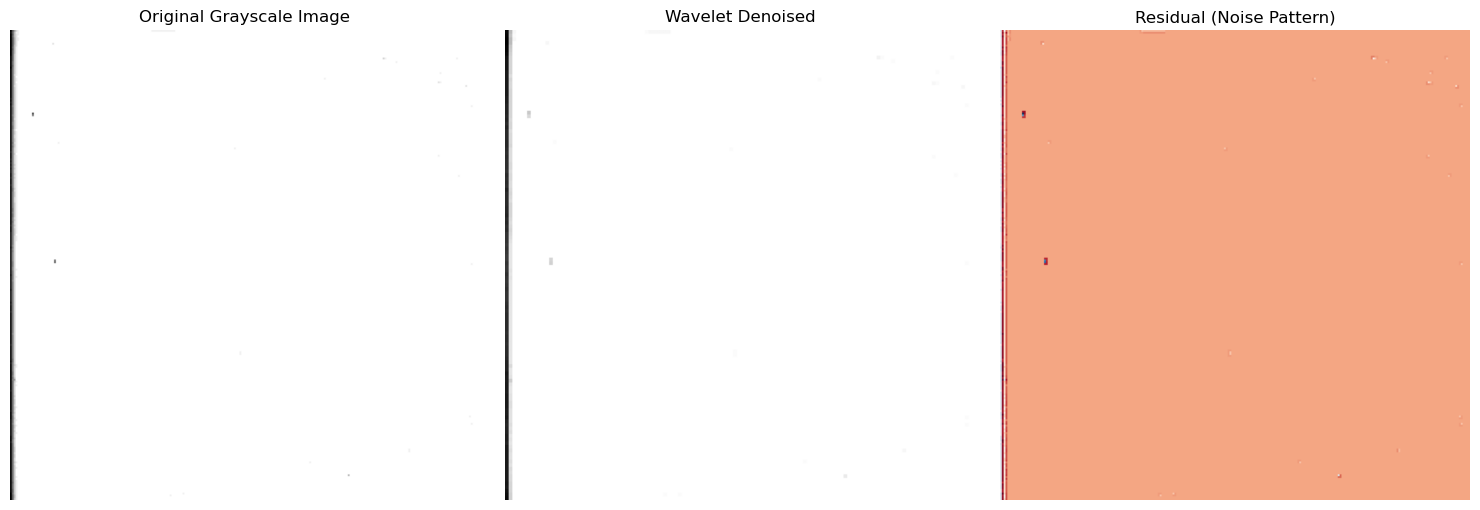

In [8]:
gray = preprocess_image(r"D:\Flatfield-20251014T111900Z-1-001\Flatfield\EpsonV550\300.tif")
residual, denoised = compute_residual(gray)

# ---------------------------
# Step 5: Visualization
# ---------------------------
plt.figure(figsize=(15,5))

plt.subplot(1,3,1)
plt.imshow(gray, cmap='gray')
plt.title("Original Grayscale Image")
plt.axis('off')

plt.subplot(1,3,2)
plt.imshow(denoised, cmap='gray')
plt.title("Wavelet Denoised")
plt.axis('off')

plt.subplot(1,3,3)
plt.imshow(residual, cmap='RdBu_r')
plt.title("Residual (Noise Pattern)")
plt.axis('off')

plt.tight_layout()
plt.show()

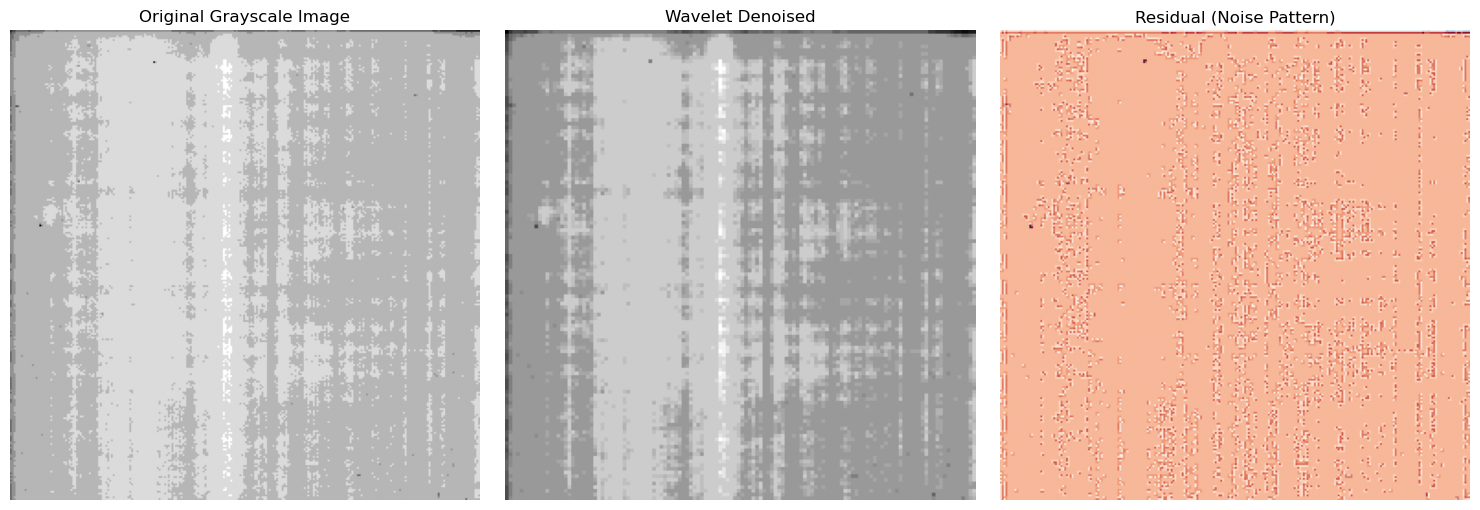

In [9]:
gray = preprocess_image(r"D:\Flatfield-20251014T111900Z-1-001\Flatfield\HP\300.tif")
residual, denoised = compute_residual(gray)

# ---------------------------
# Step 5: Visualization
# ---------------------------
plt.figure(figsize=(15,5))

plt.subplot(1,3,1)
plt.imshow(gray, cmap='gray')
plt.title("Original Grayscale Image")
plt.axis('off')

plt.subplot(1,3,2)
plt.imshow(denoised, cmap='gray')
plt.title("Wavelet Denoised")
plt.axis('off')

plt.subplot(1,3,3)
plt.imshow(residual, cmap='RdBu_r')
plt.title("Residual (Noise Pattern)")
plt.axis('off')

plt.tight_layout()
plt.show()

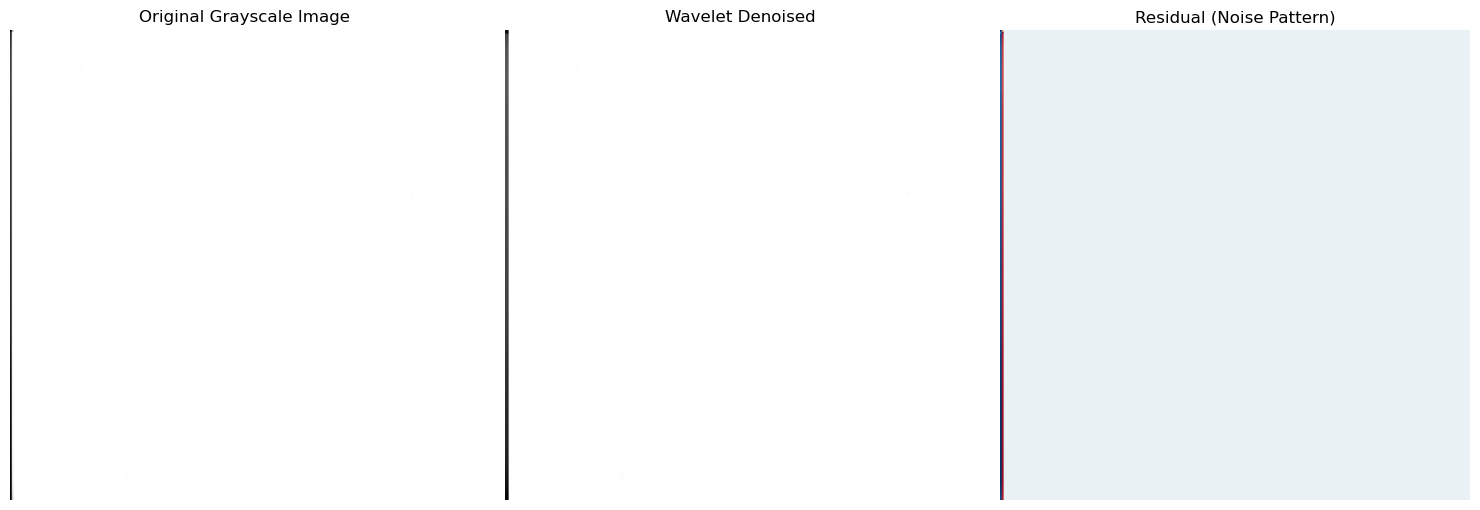

In [10]:
gray = preprocess_image(r"D:\Flatfield-20251014T111900Z-1-001\Flatfield\Canon9000-1\300.tif")
residual, denoised = compute_residual(gray)

# ---------------------------
# Step 5: Visualization
# ---------------------------
plt.figure(figsize=(15,5))

plt.subplot(1,3,1)
plt.imshow(gray, cmap='gray')
plt.title("Original Grayscale Image")
plt.axis('off')

plt.subplot(1,3,2)
plt.imshow(denoised, cmap='gray')
plt.title("Wavelet Denoised")
plt.axis('off')

plt.subplot(1,3,3)
plt.imshow(residual, cmap='RdBu_r')
plt.title("Residual (Noise Pattern)")
plt.axis('off')

plt.tight_layout()
plt.show()

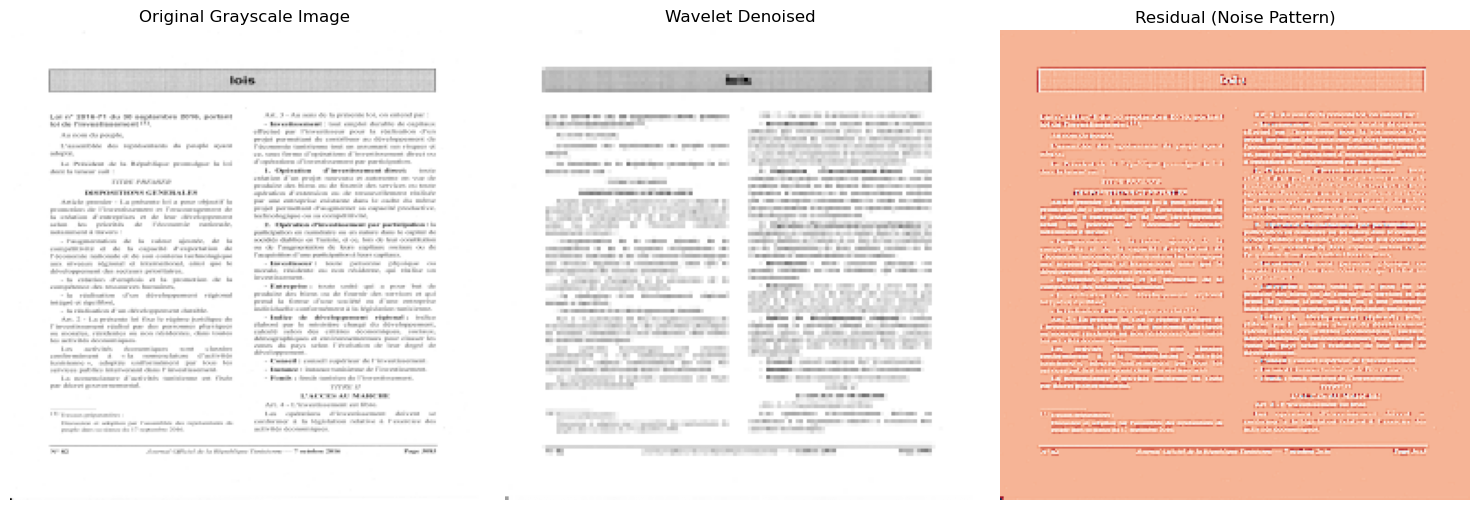

In [6]:
gray = preprocess_image(r"D:\Supatlantique Dataset\Canon9000-2\150\s5_2.tif")
residual, denoised = compute_residual(gray)

# ---------------------------
# Step 5: Visualization
# ---------------------------
plt.figure(figsize=(15,5))

plt.subplot(1,3,1)
plt.imshow(gray, cmap='gray')
plt.title("Original Grayscale Image")
plt.axis('off')

plt.subplot(1,3,2)
plt.imshow(denoised, cmap='gray')
plt.title("Wavelet Denoised")
plt.axis('off')

plt.subplot(1,3,3)
plt.imshow(residual, cmap='RdBu_r')
plt.title("Residual (Noise Pattern)")
plt.axis('off')

plt.tight_layout()
plt.show()

In [ ]:
"D:\Supatlantique Dataset\Canon9000-2\150\s5_2.tif"

In [ ]:
import pickle
import os

# Define output folder and filename
output_dir = r"D:\Flatfield-Processed"
os.makedirs(output_dir, exist_ok=True)

output_path = os.path.join(output_dir, "residual_only.pkl")

# Save the residual array directly as a pickle filw for cnn model
with open(output_path, "wb") as f:
    pickle.dump(residual.astype(np.float32), f)

print(f"✅ Residual saved to: {output_path}")

note: the pickel file saved might not be in the shape that is required for cnn input because of being single channel, so figure what shape it need to be.

In [ ]:
| Image Type                         | Contains                                                                  | Useful For                                     |
| ---------------------------------- | ------------------------------------------------------------------------- | ---------------------------------------------- |
| **Original Image**                 | Scene + Scanner noise                                                     | Not ideal — scene content dominates            |
| **Denoised Image**                 | Mostly scene (content), less device noise                                 | Good for restoration, *not* for fingerprinting |
| **Residual (Original − Denoised)** | Device-specific noise, sensor pattern noise (SPN), micro-texture patterns | ✅ Best for *scanner/source detection*          |
